In [14]:
# ===============================
# ROUND 2 – PREPROCESSING & VISUALIZATION
# ===============================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from google.colab import files

plt.style.use("seaborn-v0_8")

# ===============================
# 1️⃣ LOAD RAW DATA
# ===============================
df = pd.read_csv("/content/snapdeal_raw_data.csv")
print("Raw dataset shape:", df.shape)
df.head()


Raw dataset shape: (100, 9)


,product_name,category,price,mrp,rating,review_count,product_url,seller_name,seller_rating
0,"Wireless Bluetooth Earbuds, TWS Earbuds, Headp...",bluetooth_headphones,254,1499,4.2,5.0,https://www.snapdeal.com/product/wireless-blue...,Varni Enterprise,NaN
1,MECROLINK M19 Wireless Earbuds TWS 5.1 Dual To...,bluetooth_headphones,339,5999,4.2,16.0,https://www.snapdeal.com/product/mecrolink-m19...,NaN,NaN
2,NEO TRUE WIRELESS BLUETOOTH HEADPHONE EARBUDS ...,bluetooth_headphones,386,999,3.9,122.0,https://www.snapdeal.com/product/neo-true-wire...,Audio_M,4.0
3,Airbuds 16 Hr Bluetooth True Wireless Earbuds ...,bluetooth_headphones,282,3499,4.5,6.0,https://www.snapdeal.com/product/airbuds-16-hr...,NaN,NaN
4,"TWS Wireless Bluetooth Earbuds, TWS Earbuds, H...",bluetooth_headphones,254,999,NaN,NaN,https://www.snapdeal.com/product/tws-wireless-...,Varni Enterprise,NaN


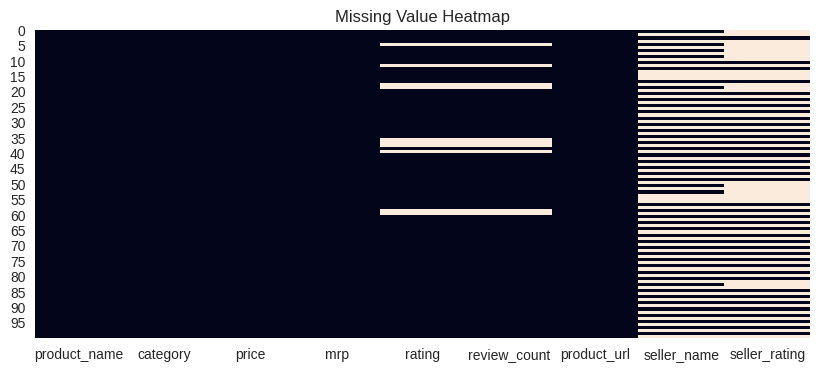

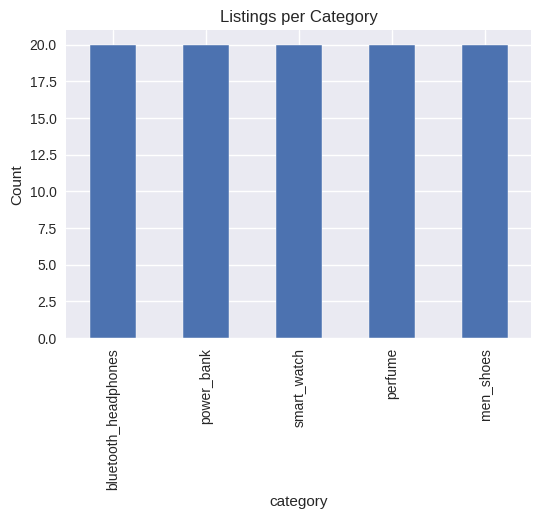

,0
product_name,object
category,object
price,int64
mrp,int64
rating,float64
review_count,float64
product_url,object
seller_name,object
seller_rating,float64


In [15]:
# Missing values
df.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

# Category distribution
plt.figure(figsize=(6,4))
df["category"].value_counts().plot(kind="bar")
plt.title("Listings per Category")
plt.ylabel("Count")
plt.show()

df.dtypes


Rows before cleaning: 100
Rows after cleaning: 90


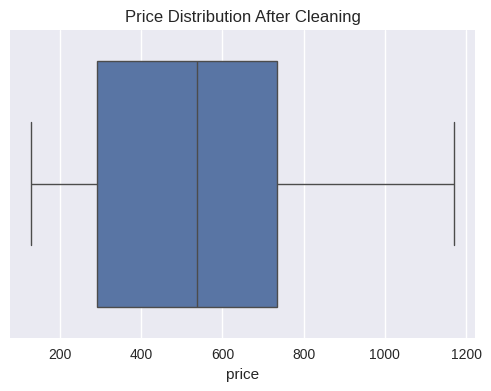

In [16]:
before = df.shape[0]

df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["mrp"] = pd.to_numeric(df["mrp"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["review_count"] = pd.to_numeric(df["review_count"], errors="coerce").fillna(0)
df["seller_rating"] = pd.to_numeric(df["seller_rating"], errors="coerce")

df = df.dropna(subset=["price", "mrp", "rating"])

after = df.shape[0]
print("Rows before cleaning:", before)
print("Rows after cleaning:", after)

plt.figure(figsize=(6,4))
sns.boxplot(x=df["price"])
plt.title("Price Distribution After Cleaning")
plt.show()


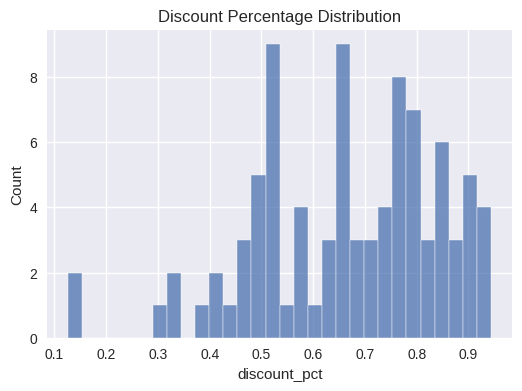

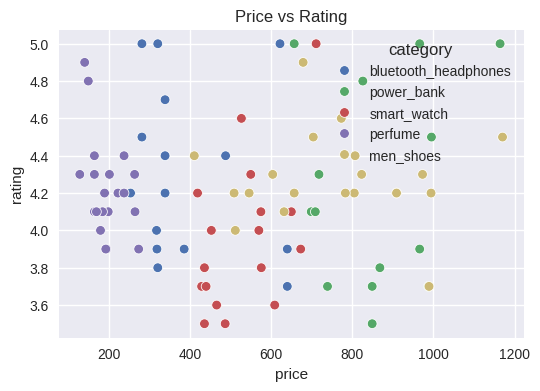

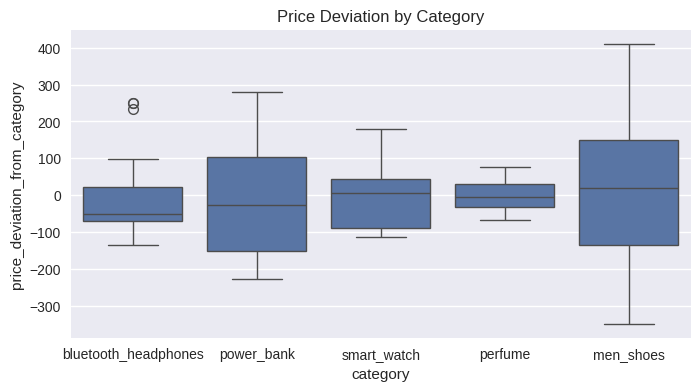

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(df["discount_pct"], bins=30)
plt.title("Discount Percentage Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="price", y="rating", hue="category")
plt.title("Price vs Rating")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="category", y="price_deviation_from_category")
plt.title("Price Deviation by Category")
plt.show()


In [20]:
df["extreme_discount_flag"] = (df["discount_pct"] > 0.6).astype(int)
df["suspicious_trust_flag"] = (df["rating_review_ratio"] < 1.2).astype(int)
df["aggressive_listing_flag"] = (
    (df["generic_word_count"] >= 3) | (df["uppercase_ratio"] > 0.25)
).astype(int)

df["risk_score"] = (
    df["extreme_discount_flag"] +
    df["suspicious_trust_flag"] +
    df["aggressive_listing_flag"]
)

df["risk_level"] = pd.cut(
    df["risk_score"],
    bins=[-1,1,3,10],
    labels=["Low","Medium","High"]
)


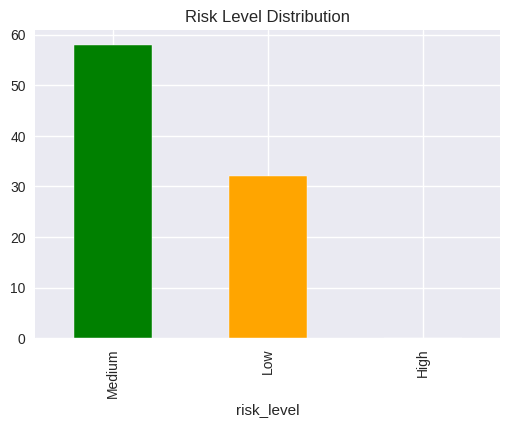

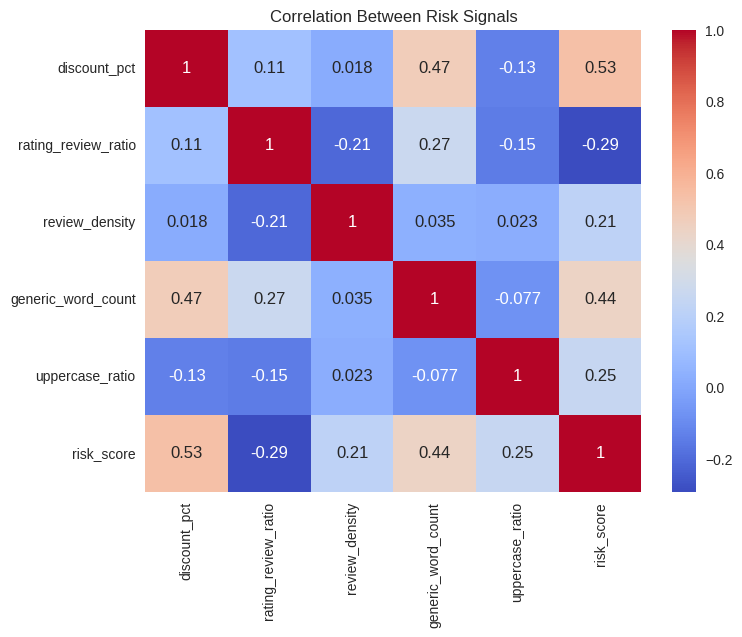

In [21]:
plt.figure(figsize=(6,4))
df["risk_level"].value_counts().plot(kind="bar", color=["green","orange","red"])
plt.title("Risk Level Distribution")
plt.show()

risk_features = [
    "discount_pct","rating_review_ratio","review_density",
    "generic_word_count","uppercase_ratio","risk_score"
]

plt.figure(figsize=(8,6))
sns.heatmap(df[risk_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Risk Signals")
plt.show()


In [22]:
cluster_features = df[
    ["price","discount_pct","rating_review_ratio",
     "generic_word_count","uppercase_ratio"]
].fillna(0)

X = StandardScaler().fit_transform(cluster_features)
df["seller_cluster_id"] = KMeans(n_clusters=5, random_state=42).fit_predict(X)


In [23]:
scaler = MinMaxScaler()
scale_cols = [
    "price","discount_pct","rating_review_ratio",
    "review_density","price_deviation_from_category"
]

df[scale_cols] = scaler.fit_transform(df[scale_cols])


In [24]:
final_file = "round2_processed_dataset.csv"
df.to_csv(final_file, index=False)
files.download(final_file)

print("✅ FINAL DATASET SHAPE:", df.shape)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ FINAL DATASET SHAPE: (90, 23)
